In [12]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from xgboost import XGBClassifier

from collections import defaultdict

import gym
from gym import spaces

import random
from scipy import stats

import joblib

%matplotlib inline

In [13]:
pd.options.display.max_columns = 40

In [14]:
data_path = "../data/Customer-Churn-Records.csv"
data = pd.read_csv(data_path)

# 1. Data Preprocessing

In [15]:
data.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 1, inplace = True)

In [16]:
def resumetable(df):    
    print(f'data shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['data type'])
    summary = summary.rename(columns = {'index': 'feature'})
    summary['num_NaN'] = df.isnull().sum().values
    summary['num_unique'] = df.nunique().values
    summary['data category'] = None
    for col in df.columns:
        if col == 'Exited':
            summary.loc[col, 'data category'] = 'Binary'
        elif df[col].dtype == object:
            summary.loc[col, 'data category'] = 'Categorical'
        elif df[col].dtype == float:
            summary.loc[col, 'data category'] = 'Numeric'
        elif df[col].dtype == int:
            summary.loc[col, 'data category'] = 'Integer'

    
    return summary

In [17]:
summary = resumetable(data)
summary

data shape: (10000, 15)


,data type,num_NaN,num_unique,data category
CreditScore,int64,0,460,Integer
Geography,object,0,3,Categorical
Gender,object,0,2,Categorical
Age,int64,0,70,Integer
Tenure,int64,0,11,Integer
Balance,float64,0,6382,Numeric
NumOfProducts,int64,0,4,Integer
HasCrCard,int64,0,2,Integer
IsActiveMember,int64,0,2,Integer
EstimatedSalary,float64,0,9999,Numeric


We can conclude that this dataset does not include any missing values. Additionally, we identified some categorical variables (Geography, Gender, Card Type). We also need to simplify the column names for easier recognition

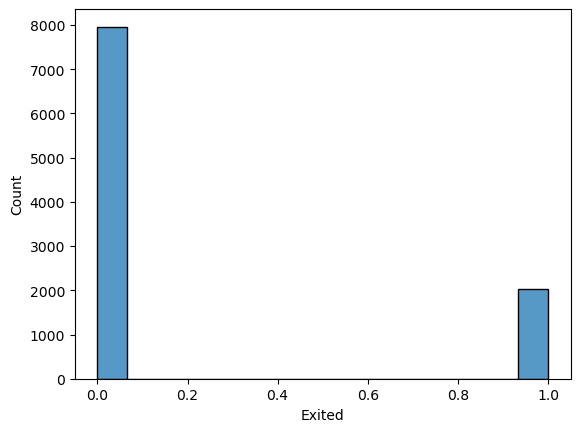

In [18]:
sns.histplot(data['Exited']);

Here, the plot suggests that the target variable is in an inbalance status, so we should focus more on the small proportion of target value 1. 

In [19]:
zero = data[data['Balance'] == 0]

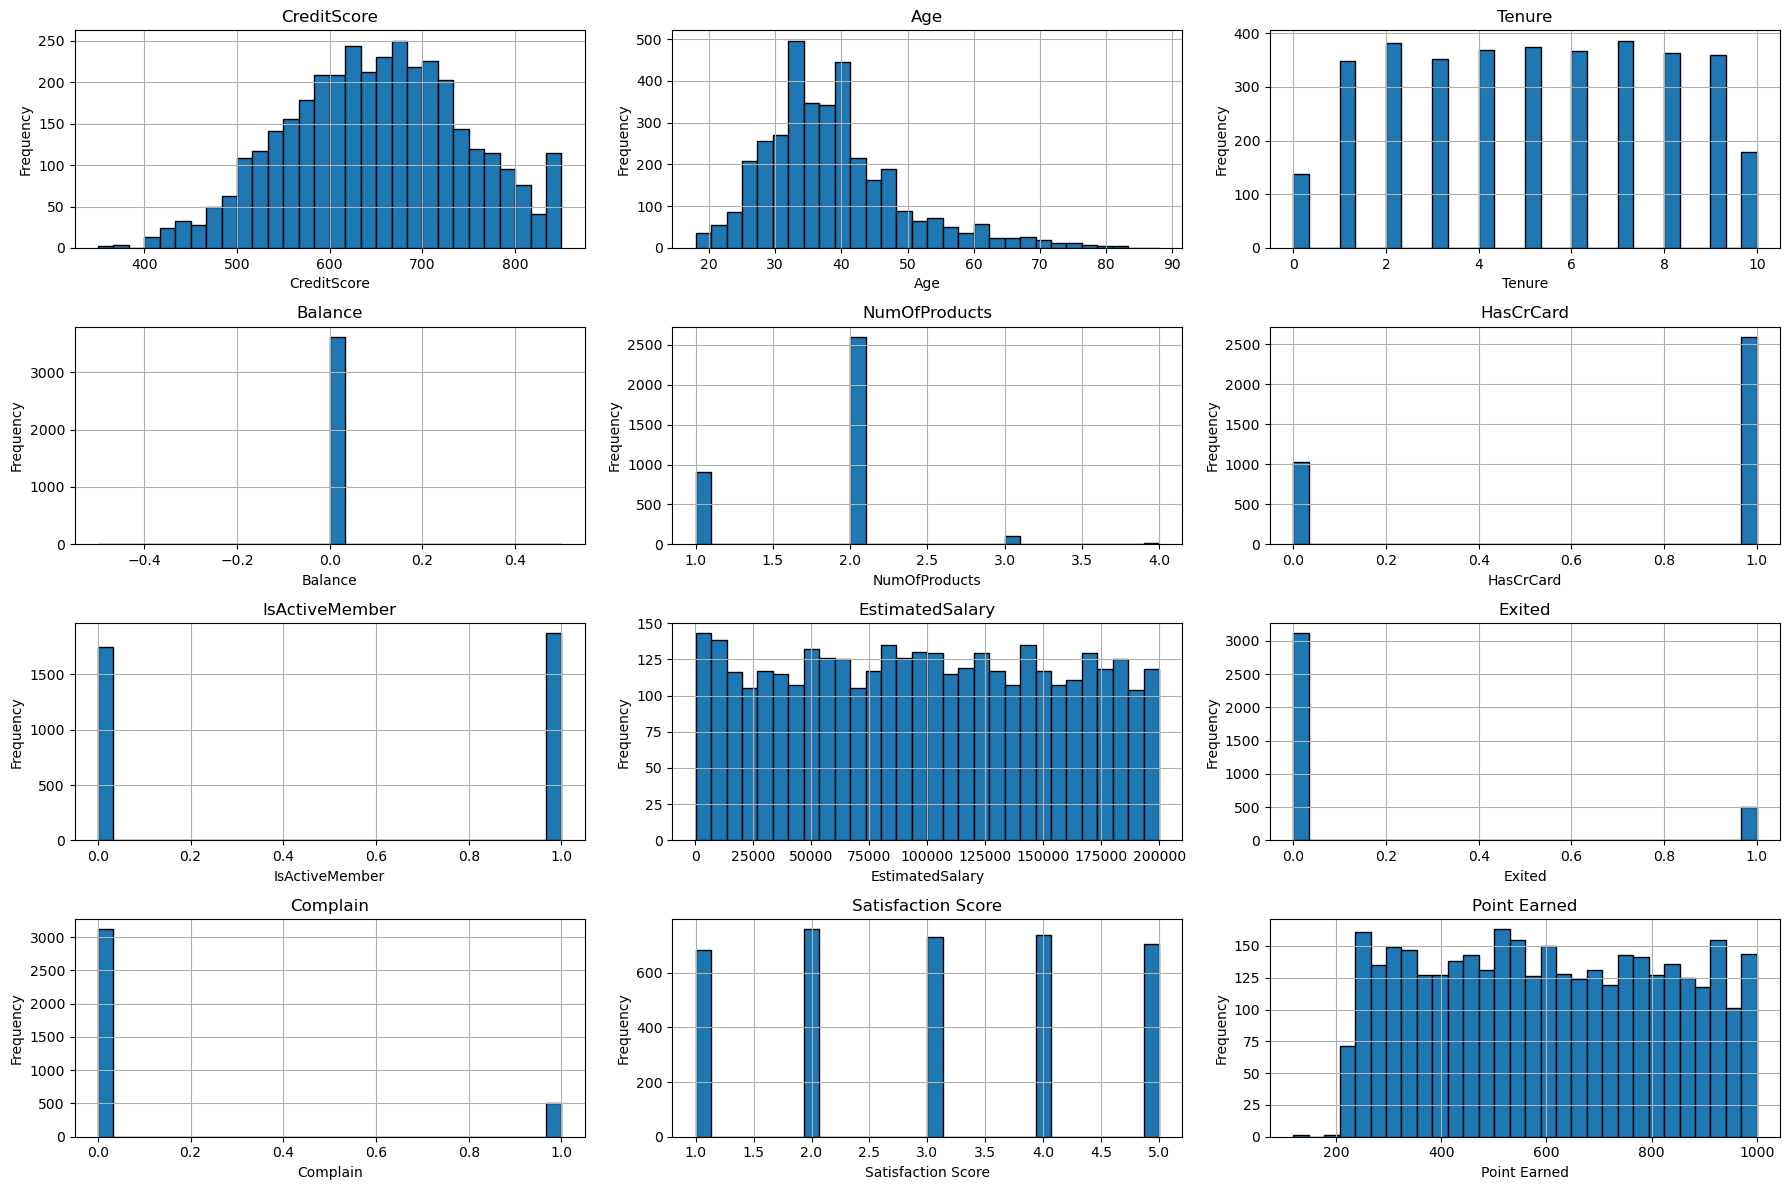

In [20]:
numeric_columns = zero.select_dtypes(include=['float64', 'int64']).columns

# Re-plot using subplots with a larger figure to avoid scrolling
plt.figure(figsize=(18, 12))  # Larger figure to fit all plots
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)  # Adjust grid size to fit all features
    zero[column].hist(bins=30, edgecolor='black')
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [21]:
round(data.describe(), 2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0,10000.0,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.2,0.2,3.01,606.52
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4,0.4,1.41,225.92
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0,0.0,1.00,119.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.0,0.0,2.00,410.00
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0,0.0,3.00,605.00
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0,0.0,4.00,801.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0,1.0,5.00,1000.00


We have a binary outcome here: 1 indicates that the customer left the bank, while 0 means the customer did not. The results suggest that the number of customers who left the bank is four times greater than the number of customers who did not churn based on this dataset.

### One-hot encoding (categorical data)

In [22]:
data = pd.get_dummies(data, columns=['Geography', 'Gender', 'Card Type'])

In [23]:
data

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,619,42,2,0.00,1,1,1,101348.88,1,1,2,464,True,False,False,True,False,True,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,1,3,456,False,False,True,True,False,True,False,False,False
2,502,42,8,159660.80,3,1,0,113931.57,1,1,3,377,True,False,False,True,False,True,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,0,5,350,True,False,False,True,False,False,True,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0,5,425,False,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,1,300,True,False,False,False,True,True,False,False,False
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,5,771,True,False,False,False,True,False,False,True,False
9997,709,36,7,0.00,1,0,1,42085.58,1,1,3,564,True,False,False,True,False,False,False,False,True
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,2,339,False,True,False,False,True,False,True,False,False


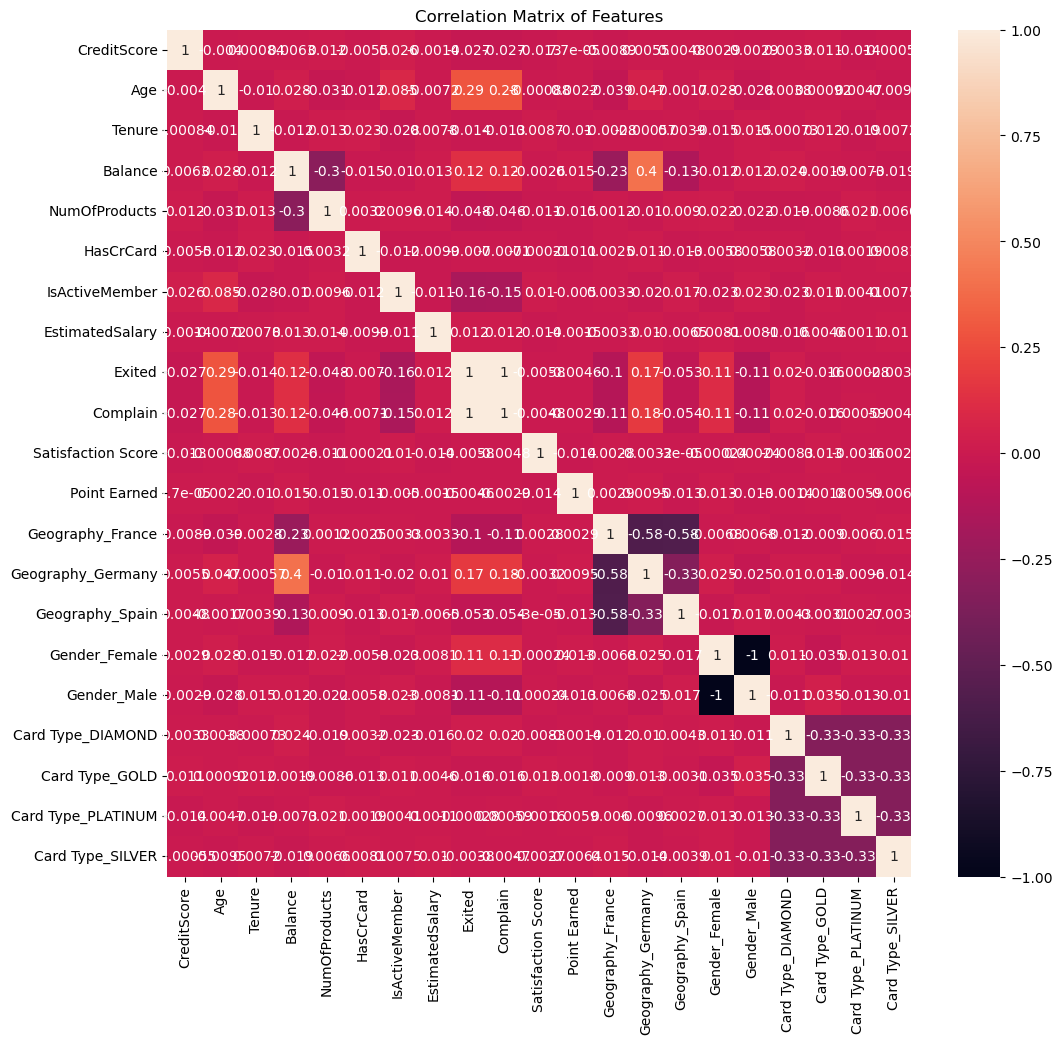

In [24]:
corr_matrix = data.corr()

plt.figure(figsize=(12, 11))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of Features')
plt.show()

### Data Scaling (pending at this point)

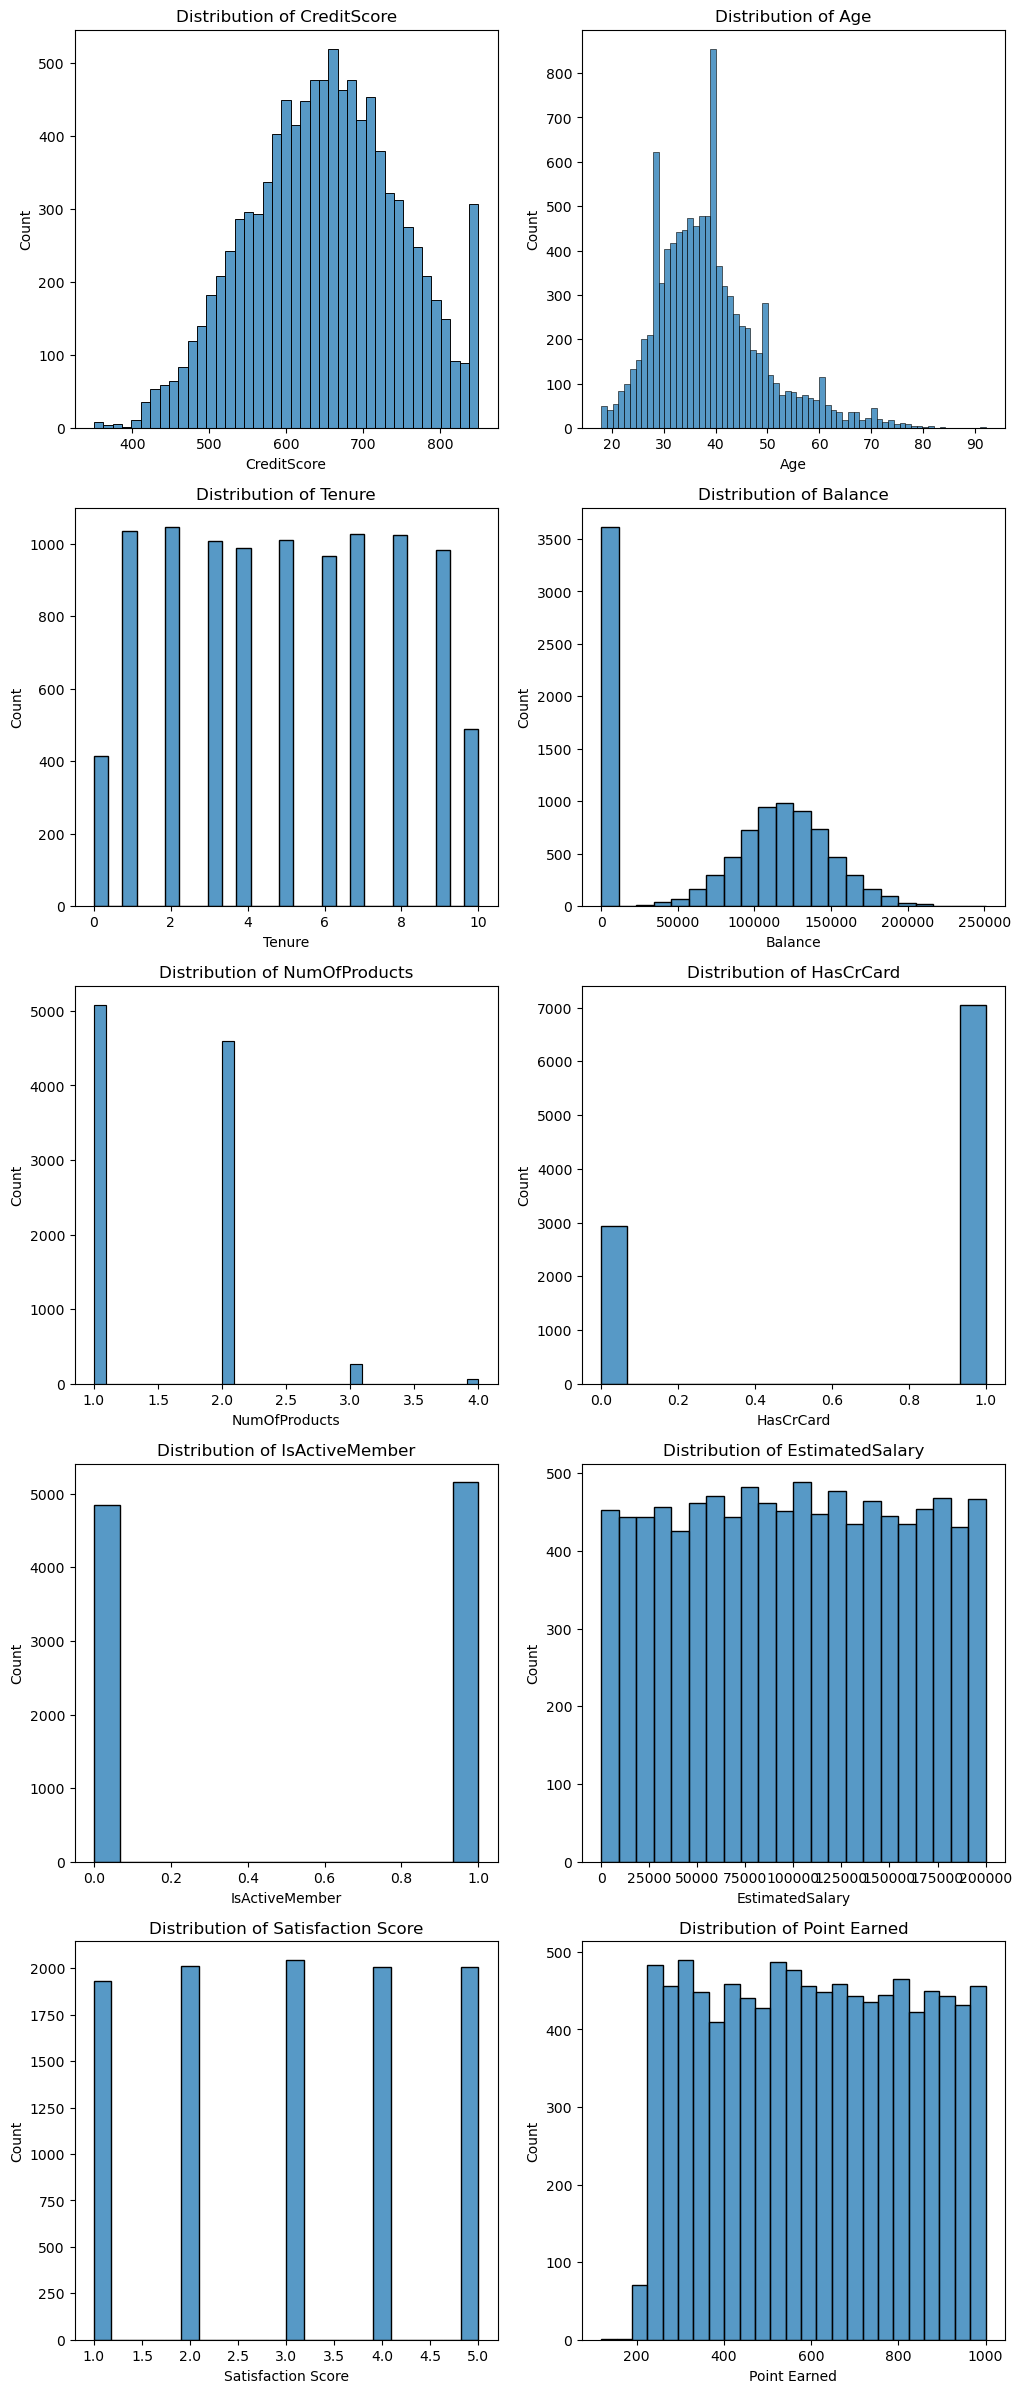

In [25]:
numeric_columns = summary[summary['data category'].isin(['Numeric', 'Integer'])].index.tolist()

if "Complain" in numeric_columns:
     numeric_columns.remove("Complain")

fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(12, 30))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col],ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

In [26]:
# standard_scaler = StandardScaler()
# min_max_scaler = MinMaxScaler()
# robust_scaler = RobustScaler()

# data[['CreditScore', 'Age']] = standard_scaler.fit_transform(data[['CreditScore', 'Age']])
# data['EstimatedSalary'] = min_max_scaler.fit_transform(data[['EstimatedSalary']])
# data[['Point Earned', 'Balance']] = robust_scaler.fit_transform(data[['Point Earned', 'Balance']])

In [27]:
data = pd.get_dummies(data, columns=['NumOfProducts', 'Satisfaction Score'])

### Feature Engineering

In [28]:
# data['Zero_Balance'] = (data['Balance'] == 0).astype(int)

In [29]:
# bins = [0, 2, 4, 6, 8, 10]
# labels = ['0-2', '3-4', '5-6', '7-8', '9-10']
# data['Tenure_bin'] = pd.cut(data['Tenure'], bins = bins, labels = labels, include_lowest = True)
# data = pd.get_dummies(data, columns = ['Tenure_bin'], prefix = 'tenure')

In [30]:
data.drop("Complain", inplace = True, axis = 1)

In [31]:
X = data.drop(columns=['Exited']) 
y = data['Exited']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = xgb.XGBClassifier(n_estimators = 500, max_depth = 3, eval_metric = "logloss")
model.fit(X_train, y_train)

pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, pred))

X_test["Exited_Probability"] = model.predict_proba(X_test)[:, 1]

data.loc[X_test.index, "Exited_Probability"] = X_test["Exited_Probability"]

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1607
           1       0.68      0.52      0.59       393

    accuracy                           0.86      2000
   macro avg       0.78      0.73      0.75      2000
weighted avg       0.85      0.86      0.85      2000



In [32]:
data

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5,Exited_Probability
0,619,42,2,0.00,1,1,101348.88,1,464,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,0.197488
1,608,41,1,83807.86,0,1,112542.58,0,456,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,NaN
2,502,42,8,159660.80,1,0,113931.57,1,377,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,NaN
3,699,39,1,0.00,0,0,93826.63,0,350,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,0.049856
4,850,43,2,125510.82,1,1,79084.10,0,425,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,1,0,96270.64,0,300,True,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,NaN
9996,516,35,10,57369.61,1,1,101699.77,0,771,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,NaN
9997,709,36,7,0.00,0,1,42085.58,1,564,True,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True,False,False,NaN
9998,772,42,3,75075.31,1,0,92888.52,1,339,False,True,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,0.007586


# 2. Exploratory Data Analysis

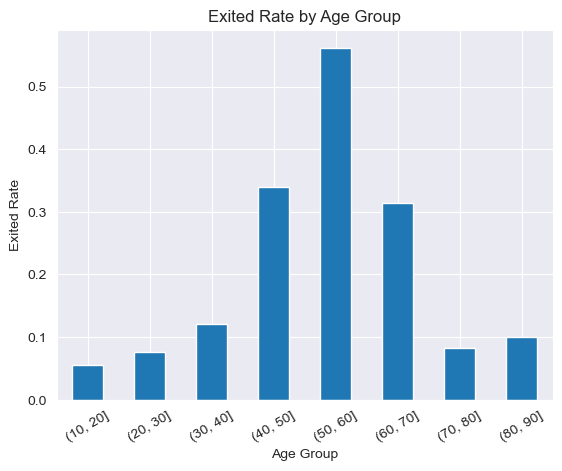

In [17]:
# Age vs Exited
age_groups = pd.cut(data['Age'], bins=range(0, 100, 10))
age_exit_ratio = data.groupby(age_groups, observed=True)['Exited'].mean()

age_exit_ratio.plot(kind = 'bar')
plt.xlabel('Age Group')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Age Group')
plt.xticks(rotation = 30);

In [18]:
age_exit_ratio

Age
(10, 20]    0.056180
(20, 30]    0.076104
(30, 40]    0.121096
(40, 50]    0.339655
(50, 60]    0.562108
(60, 70]    0.314199
(70, 80]    0.082645
(80, 90]    0.100000
Name: Exited, dtype: float64

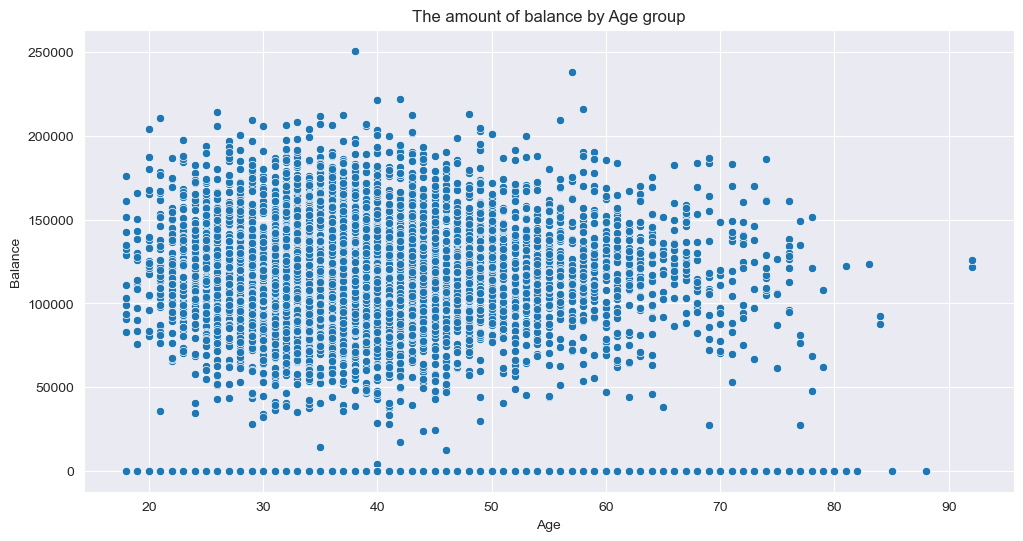

In [19]:
data[['Age', 'Balance']].sort_values(by = 'Age')

plt.figure(figsize = (12, 6))
sns.scatterplot(data, x = 'Age', y = 'Balance')
plt.title("The amount of balance by Age group");

We can perform hypothesis testing here.

Let's suppose the null hypothesis is that as age increases, the balance amount does not change. Then, the alternative hypothesis is that as age increases, the balance increases. We’ll conduct a right-tailed, one-sided test to evaluate this relationship.

One way to test this hypothesis is by examining the correlation between age and balance:

Null Hypothesis ($H_0$): There is no correlation between age and balance.

Alternative Hypothesis ($H_1$): There is a positive correlation between age and balance (i.e., as age increases, balance also increases).


This test will allow us to directly test if balance tends to increase as age increases.

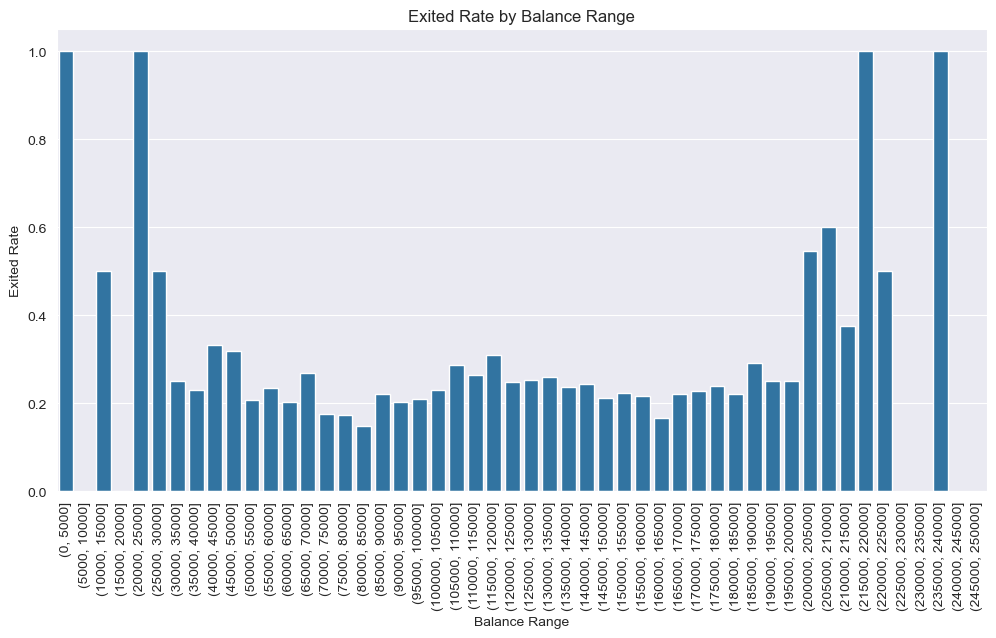

In [20]:
balance_bins = pd.cut(data['Balance'], bins=range(0, 251000, 5000))
balance_exit_ratio = data.groupby(balance_bins, observed= True)['Exited'].mean()

plt.figure(figsize = (12, 6))
sns.barplot(data = balance_exit_ratio)
plt.xlabel('Balance Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Balance Range')
plt.xticks(rotation = 90);

In [21]:
balance_exit_ratio

Balance
(0, 5000]           1.000000
(10000, 15000]      0.500000
(15000, 20000]      0.000000
(20000, 25000]      1.000000
(25000, 30000]      0.500000
(30000, 35000]      0.250000
(35000, 40000]      0.230769
(40000, 45000]      0.333333
(45000, 50000]      0.320000
(50000, 55000]      0.206897
(55000, 60000]      0.235294
(60000, 65000]      0.202703
(65000, 70000]      0.268293
(70000, 75000]      0.176991
(75000, 80000]      0.173913
(80000, 85000]      0.148515
(85000, 90000]      0.222222
(90000, 95000]      0.202429
(95000, 100000]     0.210227
(100000, 105000]    0.231405
(105000, 110000]    0.288416
(110000, 115000]    0.265356
(115000, 120000]    0.310588
(120000, 125000]    0.248889
(125000, 130000]    0.252232
(130000, 135000]    0.260638
(135000, 140000]    0.237430
(140000, 145000]    0.244224
(145000, 150000]    0.212996
(150000, 155000]    0.222707
(155000, 160000]    0.216561
(160000, 165000]    0.167883
(165000, 170000]    0.220472
(170000, 175000]    0.227273
(17500

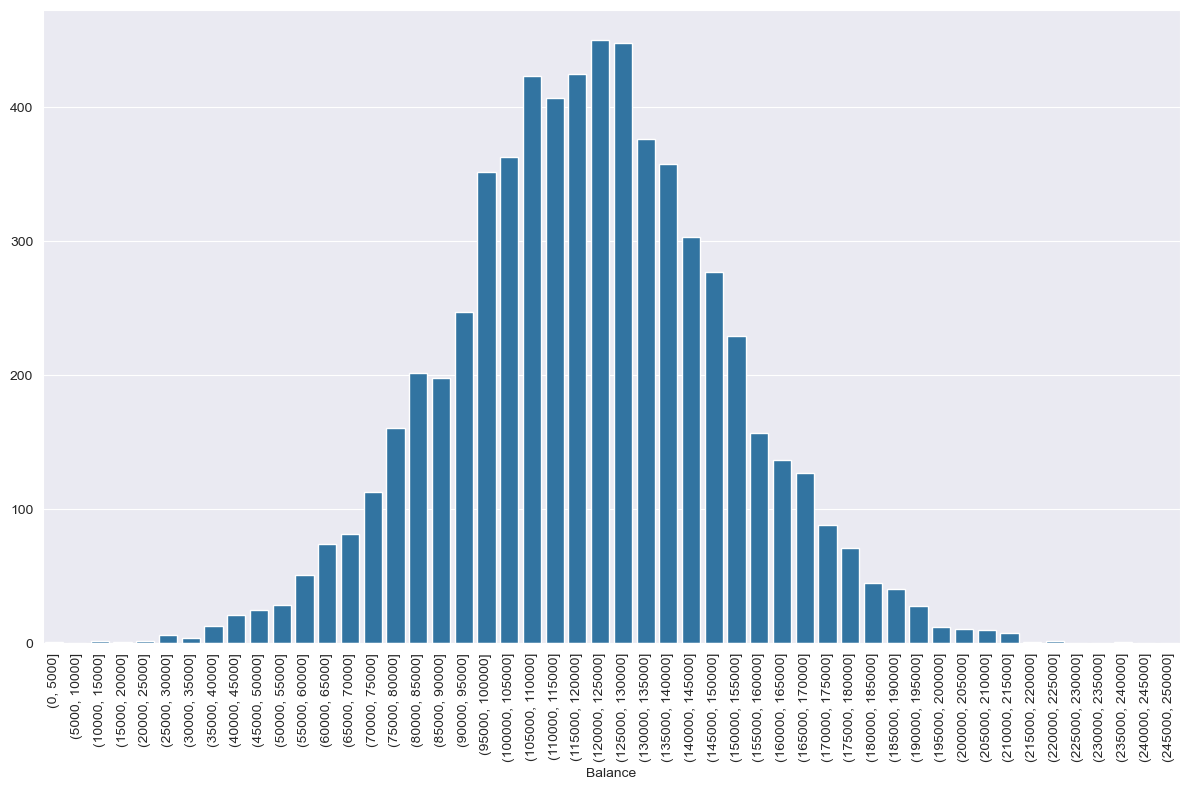

In [22]:
balance_bins_counts = balance_bins.value_counts().sort_index()

plt.figure(figsize=(12, 8))
sns.barplot(x=balance_bins_counts.index.astype(str), y=balance_bins_counts.values)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [23]:
balance_bins_counts

Balance
(0, 5000]             1
(5000, 10000]         0
(10000, 15000]        2
(15000, 20000]        1
(20000, 25000]        2
(25000, 30000]        6
(30000, 35000]        4
(35000, 40000]       13
(40000, 45000]       21
(45000, 50000]       25
(50000, 55000]       29
(55000, 60000]       51
(60000, 65000]       74
(65000, 70000]       82
(70000, 75000]      113
(75000, 80000]      161
(80000, 85000]      202
(85000, 90000]      198
(90000, 95000]      247
(95000, 100000]     352
(100000, 105000]    363
(105000, 110000]    423
(110000, 115000]    407
(115000, 120000]    425
(120000, 125000]    450
(125000, 130000]    448
(130000, 135000]    376
(135000, 140000]    358
(140000, 145000]    303
(145000, 150000]    277
(150000, 155000]    229
(155000, 160000]    157
(160000, 165000]    137
(165000, 170000]    127
(170000, 175000]     88
(175000, 180000]     71
(180000, 185000]     45
(185000, 190000]     41
(190000, 195000]     28
(195000, 200000]     12
(200000, 205000]     11
(205000,

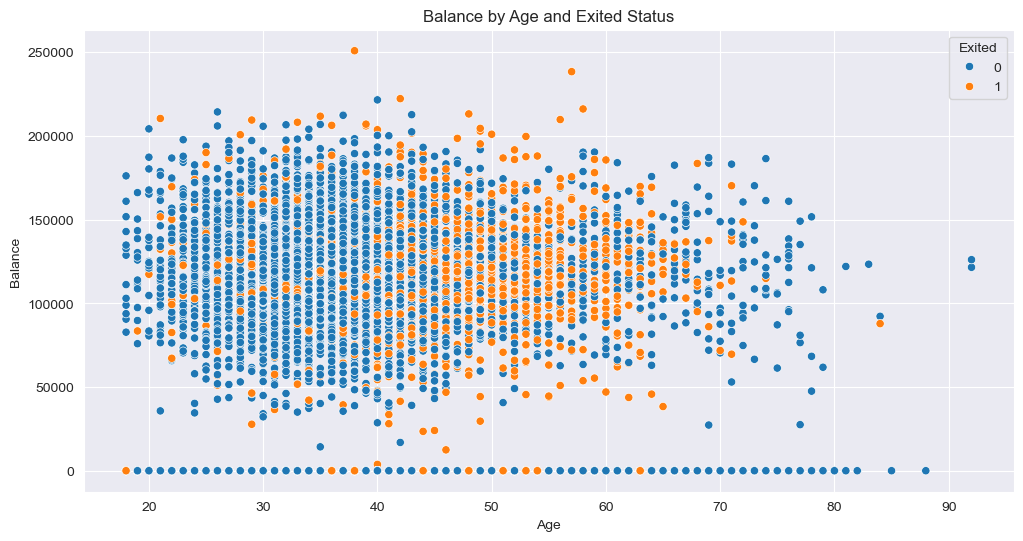

In [24]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Age', y='Balance', hue='Exited', data=data)
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('Balance by Age and Exited Status')
plt.show()

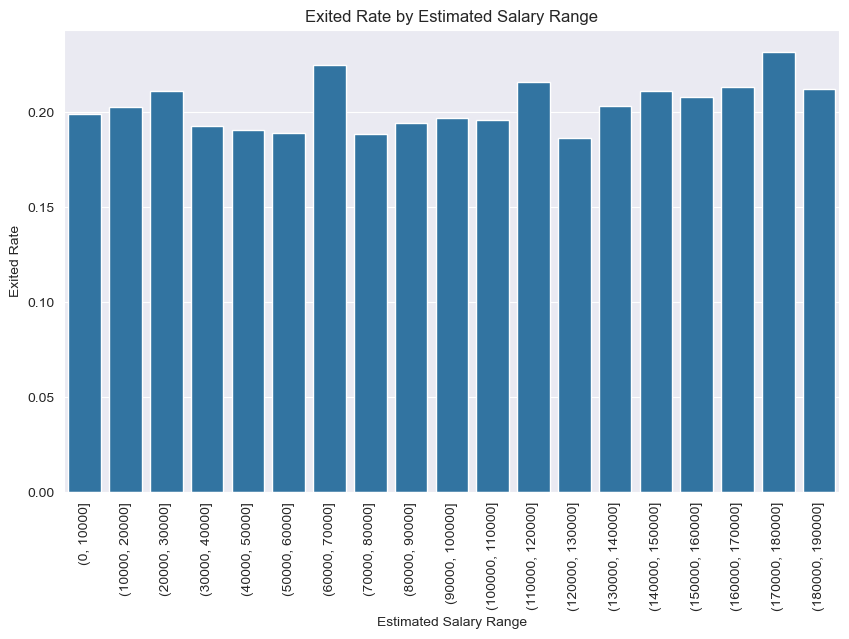

In [25]:
# Estimated Salary VS Exited
salary_bins = pd.cut(data['EstimatedSalary'], bins=range(0, 200000, 10000))
salary_exit_ratio = data.groupby(salary_bins, observed=False)['Exited'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(data = salary_exit_ratio)
plt.xlabel('Estimated Salary Range')
plt.ylabel('Exited Rate')
plt.xticks(rotation = 90)
plt.title('Exited Rate by Estimated Salary Range');

{'Card Type_DIAMOND': 0.2177901874750698, 'Card Type_GOLD': 0.1926458832933653, 'Card Type_PLATINUM': 0.2036072144288577, 'Card Type_SILVER': 0.20112179487179488}


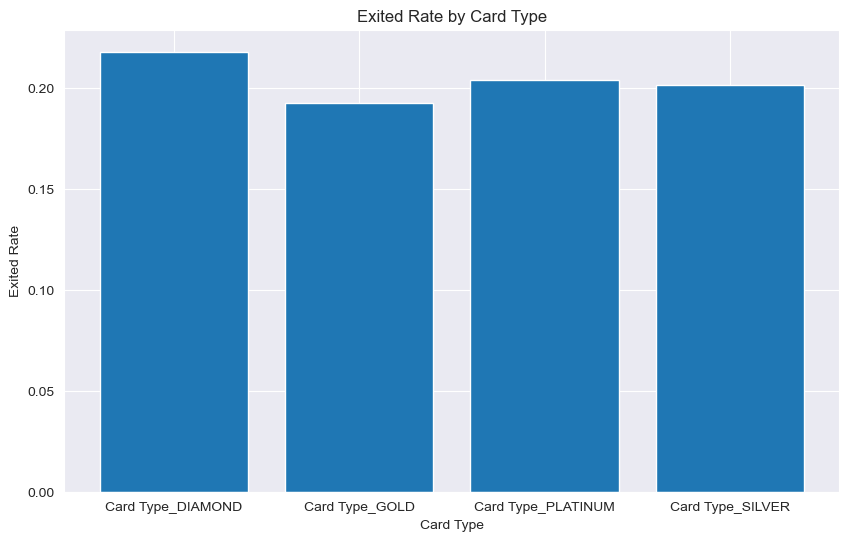

In [26]:
# Card Type VS Exited
card_types = ['Card Type_DIAMOND', 'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER']
card_exit_ratios = {}

for card_type in card_types:
    card_exit_ratios[card_type] = data.loc[data[card_type] == 1, 'Exited'].mean()

card_exit_df = pd.DataFrame(list(card_exit_ratios.items()), columns=['Card Type', 'Exited Rate'])

plt.figure(figsize = (10, 6))
plt.bar(card_exit_df['Card Type'], card_exit_df['Exited Rate'])
plt.xlabel('Card Type')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Card Type');

print(card_exit_ratios)

Point Earned
(100, 150]    0.000000
(150, 200]    1.000000
(200, 250]    0.198135
(250, 300]    0.227618
(300, 350]    0.201767
(350, 400]    0.209184
(400, 450]    0.204800
(450, 500]    0.174267
(500, 550]    0.190131
(550, 600]    0.205749
(600, 650]    0.194099
(650, 700]    0.222222
(700, 750]    0.218299
(750, 800]    0.219512
(800, 850]    0.237261
(850, 900]    0.170732
(900, 950]    0.180428
Name: Exited, dtype: float64


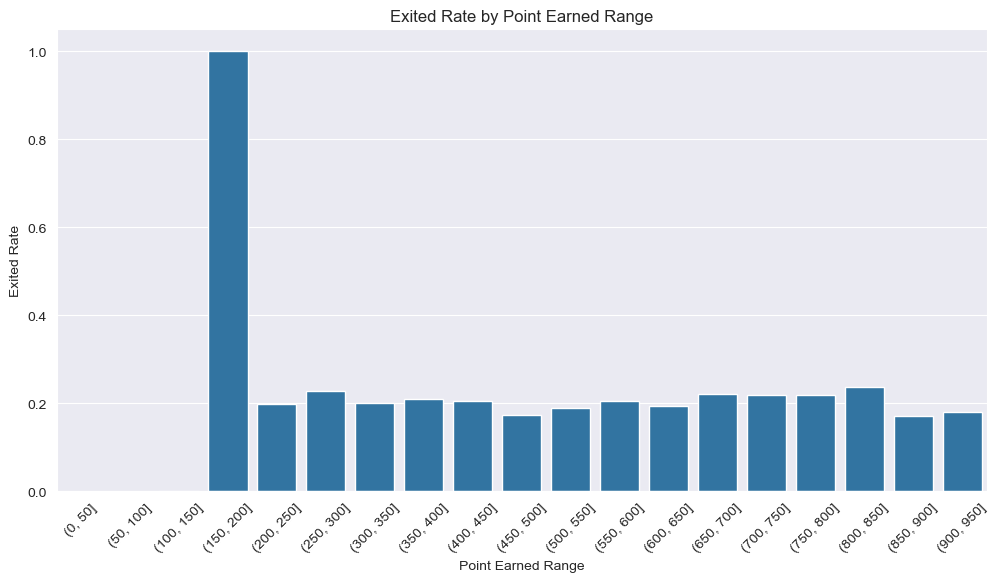

In [27]:
# Point Earned VS Exited
point_bins = pd.cut(data['Point Earned'], bins=range(0, 1000, 50))
point_exit_ratio = data.groupby(point_bins, observed = True)['Exited'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(point_exit_ratio)
plt.xlabel('Point Earned Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Point Earned Range')
plt.xticks(rotation=45);

print(point_exit_ratio)

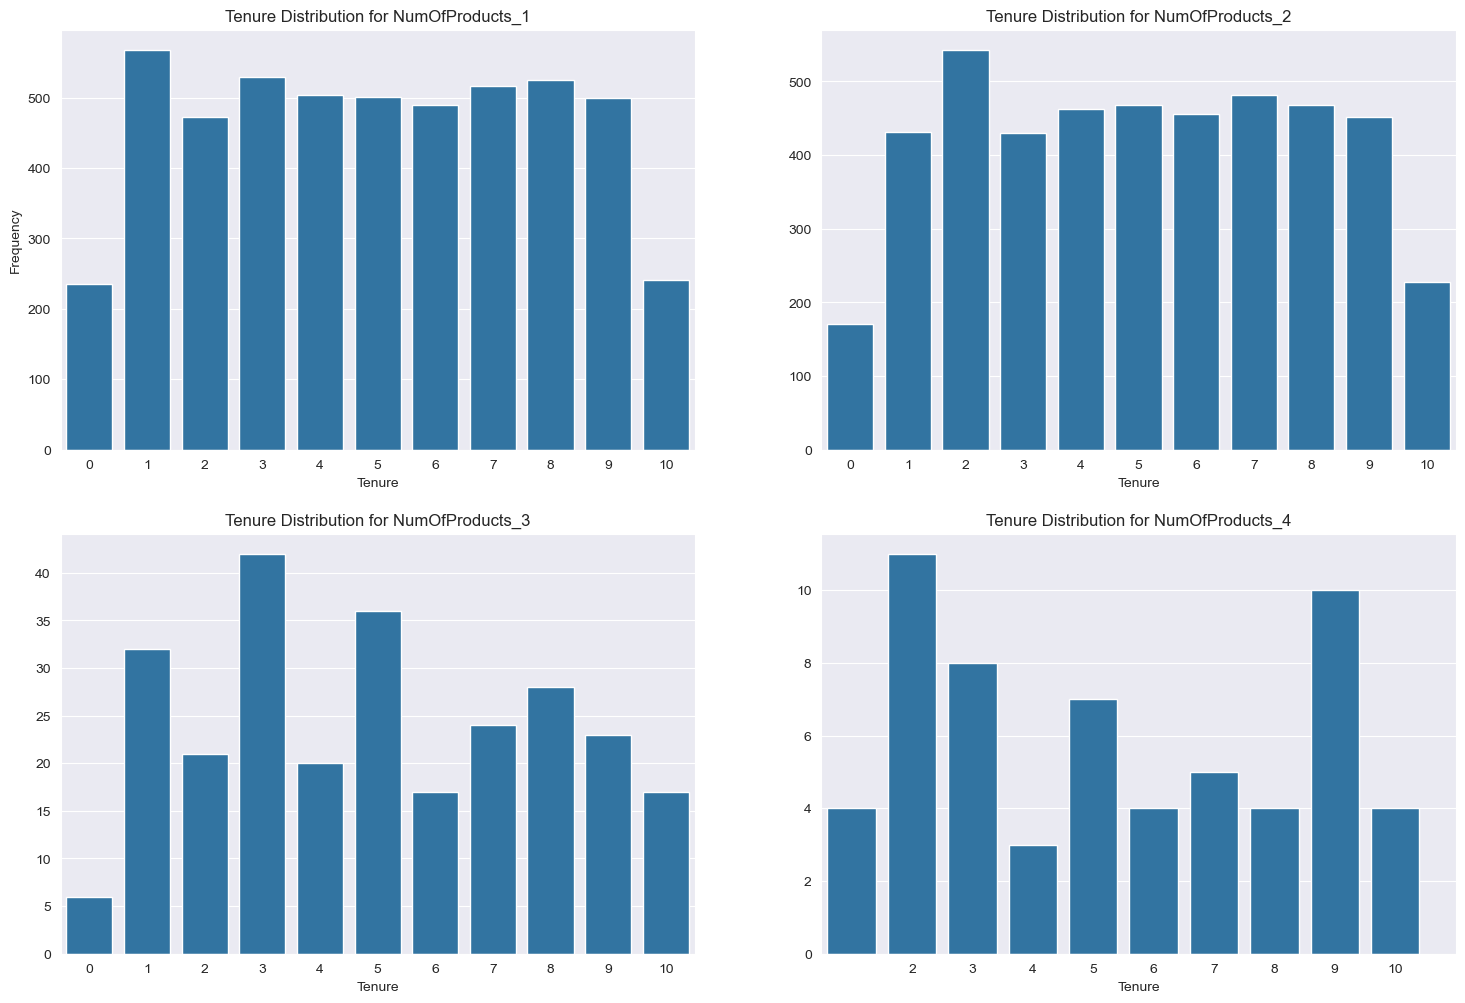

In [28]:
num_products = [f'NumOfProducts_{i}' for i in range(1, 5)]

fig, axes = plt.subplots(2, 2, figsize = (18, 12))
axes = axes.flatten()

for i, col in enumerate(num_products):
    subset = data[data[col] == 1]
    tenure_counts = subset['Tenure'].value_counts().sort_index()
    sns.barplot(x = tenure_counts.index, y = tenure_counts.values, ax = axes[i])
    
    axes[i].set_title(f'Tenure Distribution for {col}')
    axes[i].set_xlabel('Tenure')
    if i == 0:
        axes[i].set_ylabel('Frequency')
    else:
        axes[i].set_ylabel('')
    
    axes[i].set_xticks(tenure_counts.index)
    axes[i].tick_params(axis='x')

plt.show()

Balance
False    0.240953
True     0.138236
Name: Exited, dtype: float64


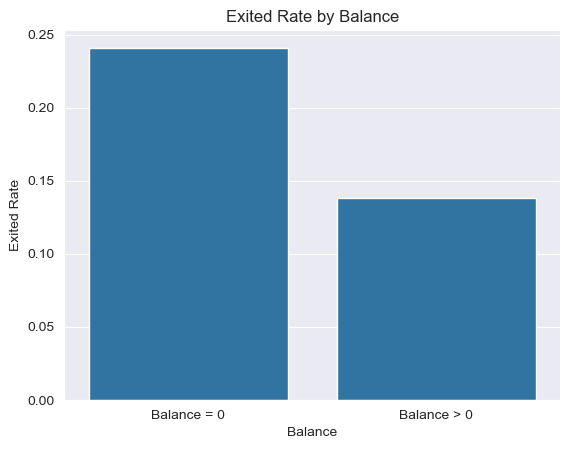

In [29]:
balance_exit_rate = data.groupby(data['Balance'] == 0)['Exited'].mean()

sns.barplot(balance_exit_rate)
plt.xticks([0, 1], ['Balance = 0', 'Balance > 0'], rotation=0)
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Balance');

print(balance_exit_rate)

In [30]:
# Complain VS Exited
complain_exit_ratio = data.groupby('Complain')['Exited'].mean()

sns.barplot(complain_exit_ratio)
plt.xlabel("Complain 0 vs 1")
plt.ylabel("Exited Rate")
plt.title("Exited Rate by Complain existence");

print(complain_exit_ratio)

KeyError: 'Complain'

# 3. Reinforcement Learning Environment Setup

In [ ]:
class ChurnEnvironment(gym.Env):
    def __init__(self, data):
        super(ChurnEnvironment, self).__init__()
        self.data = data.reset_index(drop=True)
        self.current_step = 0
        
        self.state_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary', 'Complain', 'Point Earned',
            'Geography_France', 'Geography_Germany', 'Geography_Spain',
            'Gender_Female', 'Gender_Male', 'Card Type_DIAMOND', 'Card Type_GOLD',
            'Card Type_PLATINUM', 'Card Type_SILVER', 'NumOfProducts_1',
            'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',
            'Satisfaction Score_1', 'Satisfaction Score_2', 'Satisfaction Score_3',
            'Satisfaction Score_4', 'Satisfaction Score_5']
        
        self.state_space = spaces.Box(low = 0, 
                                      high = np.inf, 
                                      shape = (len(self.state_features),), 
                                      dtype = np.float32)
        

        self.action_space = spaces.Discrete(5)
        self.actions = {
            0: "Personalized Interest Rate Adjustment",
            1: "Customized Product Bundling",
            2: "Age-based Promotion",
            3: "Customized Product Bundle",
            4: "Immediate Personalized Resolution"}
        
    def reset(self):
        """
        Select random customer data as initial state at the start of each episode
        """
        self.current_step = np.random.randint(0, len(self.data)) # 무작위 고객 데이터 선택해 초기 상태 반환 
        return self._get_state()
    
    def _get_state(self):
        """
        Return the current state vector
        """
        state = self.data.loc[self.current_step, self.state_features].values
        return state.astype(np.float32)

    def calculate_reward(self, customer, action):
        reward = 0

        # 1. Personalized Interest Rate Adjustment (완료)
        if action == 0: 
            if customer['CreditScore'] < 579:
                reward += 0.06
            elif 580 <= customer['CreditScore'] <= 669:
                reward += 0.08
            elif 670 <= customer['CreditScore'] <= 739:
                reward += 0.06
            elif 740 <= customer['CreditScore'] <= 799:
                reward += 0.03
            else:
                reward += 0
                

        # 2. Financial Planning Assistance (완료)
        elif action == 1:
            if customer['Balance'] >= 200000:
                reward -= 0.1
            else:
                reward += 0.03

        # 3. Age-based Promotion (완료)
        elif action == 2:
            if customer['Age'] < 40:
                reward += 0.03  
            elif 40 <= customer['Age'] < 50:
                reward -= 0.05  
            elif 50 <= customer['Age'] < 60:
                reward -= 0.1  # Highest churn rate age group
            elif 60 <= customer['Age'] < 70:
                reward -= 0.05
            else:
                reward += 0.03
                
        # 4. Customized Product Bundling (완료)
        elif action == 3:
            if customer['NumOfProducts_1']:
                reward += 0.04
            elif customer['NumOfProducts_2']:
                reward += 0.08 # 가장 낮은 이탈률을 보여 1보다 높게 포인트 부여
            elif customer['NumOfProducts_3']:
                reward -= 0.05  # 제품 수 3개인 경우 페널티
            elif customer['NumOfProducts_4']:
                reward -= 0.1  # 제품 수 4개인 경우 강한 페널티

        # 4. Immediate Personalized Resolution 
        elif action == 4:
            if customer['Complain'] == 0:
                reward += 0.1
            else:
                reward -= 0.2
                
        if customer['Exited'] == 0:
            reward += 1.0  # Reward if customer is retained
        else:
            reward -= 1.0  # Penalty if customer has exited
        return reward

    def step(self, action):
        """
        Executes a given action for the current customer in the environment, updates the environment state, 
        and returns the result of this action
        """
        customer = self.data.loc[self.current_step] #customer data at the current step
        reward = self.calculate_reward(customer, action)  #calculate the reward based on selected customer and action
        done = False

        if customer["Exited"] ==1 :
            done = True
            next_state = np.zeros(self.state_space.shape)
        else:
            self.current_step += 1
            if self.current_step >= len(self.data):
                done = True
                next_state = np.zeros(self.state_space.shape)
            else:
                next_state = self._get_state()

        return next_state, reward, done, {}

# 4. Baseline Model (xgboost)

In [37]:
data

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5,Exited_Probability
0,619,42,2,0.00,1,1,101348.88,1,464,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,0.197488
1,608,41,1,83807.86,0,1,112542.58,0,456,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,NaN
2,502,42,8,159660.80,1,0,113931.57,1,377,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,NaN
3,699,39,1,0.00,0,0,93826.63,0,350,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,0.049856
4,850,43,2,125510.82,1,1,79084.10,0,425,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,1,0,96270.64,0,300,True,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,NaN
9996,516,35,10,57369.61,1,1,101699.77,0,771,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,NaN
9997,709,36,7,0.00,0,1,42085.58,1,564,True,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True,False,False,NaN
9998,772,42,3,75075.31,1,0,92888.52,1,339,False,True,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,0.007586


In [33]:
X = data.drop(columns=['Exited', 'Exited_Probability'])
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = xgb.XGBClassifier(n_estimators = 500, max_depth = 3)

model.fit(X_train, y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

0.85
[[1499   90]
 [ 210  201]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1589
           1       0.69      0.49      0.57       411

    accuracy                           0.85      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.84      0.85      0.84      2000



In [34]:
data

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5,Exited_Probability
0,619,42,2,0.00,1,1,101348.88,1,464,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,0.197488
1,608,41,1,83807.86,0,1,112542.58,0,456,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,NaN
2,502,42,8,159660.80,1,0,113931.57,1,377,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,NaN
3,699,39,1,0.00,0,0,93826.63,0,350,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,0.049856
4,850,43,2,125510.82,1,1,79084.10,0,425,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,1,0,96270.64,0,300,True,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,NaN
9996,516,35,10,57369.61,1,1,101699.77,0,771,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,NaN
9997,709,36,7,0.00,0,1,42085.58,1,564,True,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True,False,False,NaN
9998,772,42,3,75075.31,1,0,92888.52,1,339,False,True,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,0.007586


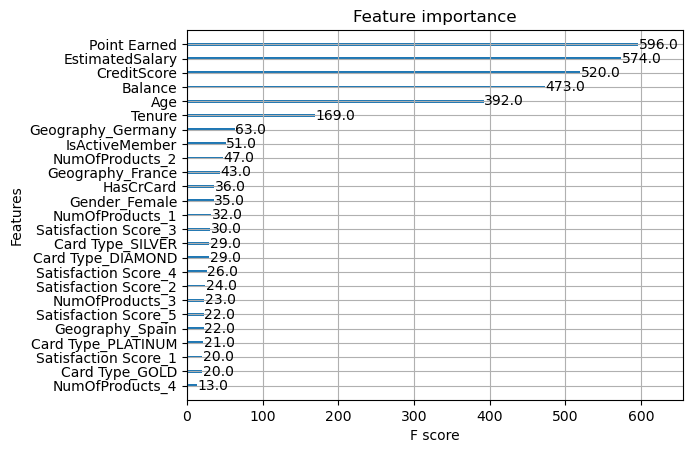

In [35]:
xgb.plot_importance(model)
plt.show()

In [36]:
joblib.dump(model, "xgboost_churn_model.pkl")

['xgboost_churn_model.pkl']

In [ ]:
# feature_imp = pd.DataFrame({"features": X_train.columns, "values": model.feature_importances_})
# feature_imp.sort_values(by = 'values', ascending= False, inplace = True)
# feature_imp

# 5. Reinforcement Learning Agent Setup

In [ ]:
# Testing the trained agent
import numpy as np
import random
import gym

class QLearning:
    def __init__(self, env, learning_rate = 0.1, gamma = 0.9, epsilon = 0.9, epsilon_decay = 0.995, epsilon_min = 0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((len(env.data), env.action_space.n))
        self.rewards_per_episode = []

    def select_action(self, state_index):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.env.action_space.n - 1)  # 탐험, 무작위로 action을 뽑는다
        else:
            return np.argmax(self.q_table[state_index])  # 최적 행동, 즉 보상을 극대화하는 정책을 선택한다

    def train(self, num_episodes):
        for episode in range(num_episodes):
            state = self.env.reset()  
            done = False
            total_reward = 0
            state_index = self.env.current_step  # 현재 상태의 인덱스를 가져옴

            while not done:
                action = self.select_action(state_index)  # 행동 선택
                next_state, reward, done, _ = self.env.step(action)  # 행동 수행 및 보상과 다음 상태 얻기
                next_state_index = self.env.current_step if not done else state_index

                # Q 테이블 업데이트
                old_value = self.q_table[state_index, action]
                next_max = np.max(self.q_table[next_state_index])
                    # 가치 평가를 통해 새로운 value로 업데이트
                self.q_table[state_index, action] = old_value + self.learning_rate * (reward + self.gamma * next_max - old_value)
                
                # 상태 업데이트
                state = next_state
                state_index = next_state_index
                total_reward += reward
                
            # 그래프 생성을 위한 리워드 포인트 누적
            self.rewards_per_episode.append(total_reward)

            # 탐험률 감소
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

        print("End")

def evaluate_agent(env, agent):
    total_customers = len(env.data)
    exited_customers = 0

    for i in range(total_customers):
        customer = env.data.loc[i, env.state_features].values.reshape(1, -1)
        action = np.argmax(agent.q_table[i])  
        if env.data.loc[i, 'Exited'] == 1:
            exited_customers += 1

    exit_rate = exited_customers / total_customers
    print(f"이탈률: {exit_rate * 100:.2f}%")

# 환경 초기화
env = ChurnEnvironment(data)
agent = QLearning(env)
agent.train(num_episodes= 5000)
evaluate_agent(env, agent)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(agent.rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward")
plt.show()